In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Embedding, GRU, Dense, GlobalAveragePooling2D, Conv2DTranspose, Reshape
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
IMG_H = IMG_W = 128
BATCH_SIZE = 16
LATENT_DIM = 256
EMBED_DIM = 256
HIDDEN_DIM = 512
MAX_TOKENS = 2000
MAX_LEN = 30
EPOCHS = 10

CAP_PATH = "/content/drive/MyDrive/captions.csv"
IMG_DIR = "/content/drive/MyDrive/images/"


In [34]:
MAX_TOKENS = 2000
MAX_LEN = 30

df = pd.read_csv(CAP_PATH)
df = df.groupby('image').head(5)
unique_images = df['image'].unique()[:1000]
df = df[df['image'].isin(unique_images)].reset_index(drop=True)

# Cleaning captions manually
def clean_caption(caption):
    caption = caption.lower()
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    return f"<start> {caption.strip()} <end>"

df['caption'] = df['caption'].apply(clean_caption)

# Creating vectorizer and adapt vocab
vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=MAX_LEN,
    standardize=None
)

vectorizer.adapt(df['caption'].values)

vocab = vectorizer.get_vocabulary()
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
VOCAB_SIZE = len(vocab)

caption_seqs = vectorizer(df['caption'].values)


In [35]:
# Inception V3 Encoder
def build_cnn_encoder():
    base_model = InceptionV3(include_top=False, weights='imagenet')
    output = base_model.output
    output = GlobalAveragePooling2D()(output)
    return Model(inputs=base_model.input, outputs=output)


In [36]:
# Architecture
class VAEModel(tf.keras.Model):
    def __init__(self, latent_dim, vocab_size, embed_dim, hidden_dim):
        super(VAEModel, self).__init__()
        self.encoder_cnn = build_cnn_encoder()
        self.fc_mu = Dense(latent_dim)
        self.fc_logvar = Dense(latent_dim)

        self.img_decoder_fc = Dense(8*8*256, activation='relu')
        self.img_decoder_reshape = Reshape((8, 8, 256))
        self.img_decoder_deconv = tf.keras.Sequential([
            Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),
            Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid')  # Final shape: 64x64x3
        ])

        self.embed = Embedding(vocab_size, embed_dim)
        self.init_state = Dense(hidden_dim, activation='tanh')
        self.gru = GRU(hidden_dim, return_sequences=True, return_state=True)
        self.fc_output = Dense(vocab_size)

    def encode(self, images):
        features = self.encoder_cnn(images)
        mu = self.fc_mu(features)
        logvar = self.fc_logvar(features)
        eps = tf.random.normal(shape=tf.shape(mu))
        z = mu + tf.exp(0.5 * logvar) * eps
        return z, mu, logvar

    def decode_image(self, z):
        x = self.img_decoder_fc(z)
        x = self.img_decoder_reshape(x)
        return self.img_decoder_deconv(x)

    def decode_caption(self, z, captions):
        x = self.embed(captions)
        h0 = self.init_state(z)
        x, _ = self.gru(x, initial_state=h0)
        return self.fc_output(x)

    def call(self, images, captions):
        z, mu, logvar = self.encode(images)
        recon_img = self.decode_image(z)
        pred_captions = self.decode_caption(z, captions)
        return recon_img, pred_captions, mu, logvar


In [37]:

def vae_loss_fn(img_true, img_pred, cap_true, cap_pred, mu, logvar):
    recon_loss = tf.reduce_mean(tf.square(img_true - img_pred))
    ce_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(cap_true, cap_pred, from_logits=True))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))
    return recon_loss + ce_loss + kl_loss, recon_loss, ce_loss, kl_loss

@tf.function
def train_step(model, images, cap_in, cap_out, optimizer):
    with tf.GradientTape() as tape:
        recon_img, cap_pred, mu, logvar = model(images, cap_in)
        loss, recon_loss, ce_loss, kl_loss = vae_loss_fn(images, recon_img, cap_out, cap_pred, mu, logvar)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, recon_loss, ce_loss, kl_loss


In [38]:

AUTOTUNE = tf.data.AUTOTUNE

def load_image_tensor(filename):
    path = tf.strings.join([IMG_DIR, filename])
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    return preprocess_input(img)

image_paths = df['image'].values
cap_in = caption_seqs[:, :-1]
cap_out = caption_seqs[:, 1:]

dataset = tf.data.Dataset.from_tensor_slices((image_paths, cap_in, cap_out))

def map_func(img_file, c1, c2):
    return load_image_tensor(img_file), c1, c2

dataset = dataset.map(map_func, num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [39]:
#Training
model = VAEModel(LATENT_DIM, VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
optimizer = Adam()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    total_loss = total_recon = total_ce = total_kl = 0
    steps = 0
    for images, cap_in, cap_out in dataset:
        loss, recon, ce, kl = train_step(model, images, cap_in, cap_out, optimizer)
        total_loss += loss
        total_recon += recon
        total_ce += ce
        total_kl += kl
        steps += 1
    print(f"Loss: {total_loss/steps:.4f}, Recon: {total_recon/steps:.4f}, CE: {total_ce/steps:.4f}, KL: {total_kl/steps:.4f}")


Epoch 1/10
Loss: 2.9160, Recon: 0.3240, CE: 2.1168, KL: 0.4752
Epoch 2/10
Loss: 1.8471, Recon: 0.3088, CE: 1.5379, KL: 0.0005
Epoch 3/10
Loss: 1.7033, Recon: 0.3086, CE: 1.3946, KL: 0.0000
Epoch 4/10
Loss: 1.6014, Recon: 0.3086, CE: 1.2928, KL: 0.0000
Epoch 5/10
Loss: 1.5099, Recon: 0.3086, CE: 1.2013, KL: 0.0000
Epoch 6/10
Loss: 1.4243, Recon: 0.3086, CE: 1.1157, KL: 0.0000
Epoch 7/10
Loss: 1.3339, Recon: 0.3086, CE: 1.0254, KL: 0.0000
Epoch 8/10
Loss: 1.2449, Recon: 0.3086, CE: 0.9362, KL: 0.0000
Epoch 9/10
Loss: 1.1571, Recon: 0.3087, CE: 0.8484, KL: 0.0000
Epoch 10/10
Loss: 1.0737, Recon: 0.3089, CE: 0.7649, KL: 0.0000


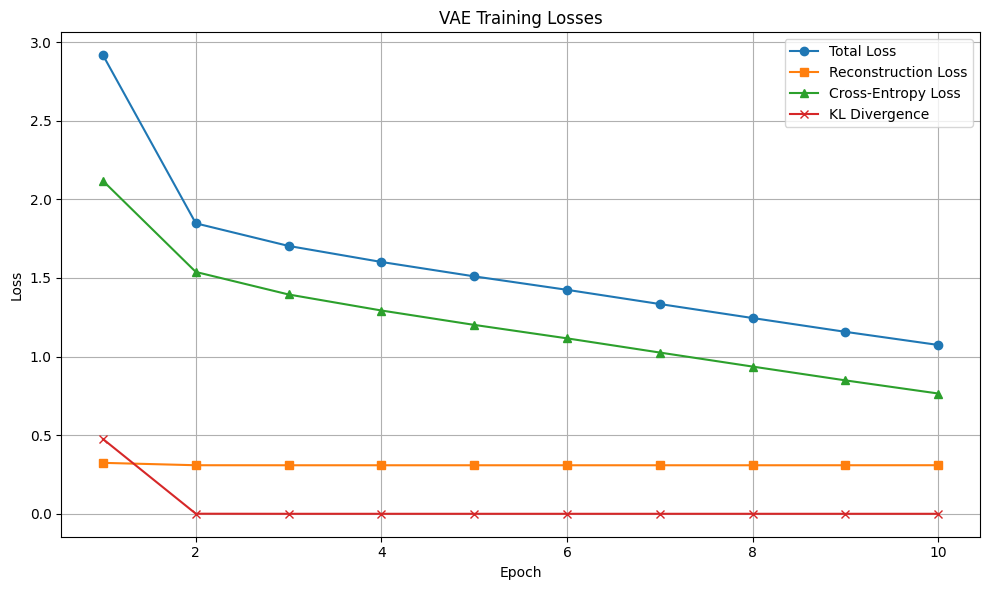

In [260]:
import matplotlib.pyplot as plt
epochs = list(range(1, 11))
total_loss = [2.9160, 1.8471, 1.7033, 1.6014, 1.5099, 1.4243, 1.3339, 1.2449, 1.1571, 1.0737]
recon_loss = [0.3240, 0.3088, 0.3086, 0.3086, 0.3086, 0.3086, 0.3086, 0.3086, 0.3087, 0.3089]
ce_loss =    [2.1168, 1.5379, 1.3946, 1.2928, 1.2013, 1.1157, 1.0254, 0.9362, 0.8484, 0.7649]
kl_loss =    [0.4752, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]

plt.figure(figsize=(10, 6))
plt.plot(epochs, total_loss, label='Total Loss', marker='o')
plt.plot(epochs, recon_loss, label='Reconstruction Loss', marker='s')
plt.plot(epochs, ce_loss, label='Cross-Entropy Loss', marker='^')
plt.plot(epochs, kl_loss, label='KL Divergence', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


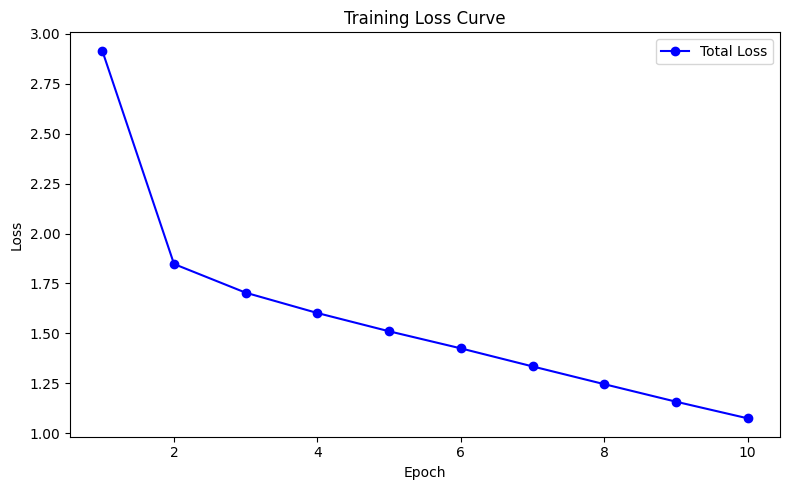

In [262]:
import matplotlib.pyplot as plt

# Epochs and total loss values
epochs = list(range(1, 11))
total_loss = [2.9160, 1.8471, 1.7033, 1.6014, 1.5099, 1.4243, 1.3339, 1.2449, 1.1571, 1.0737]

# Plotting total loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, total_loss, marker='o', label='Total Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
import numpy as np
import tensorflow as tf

def generate_caption(model, image_path, vectorizer, word2idx, idx2word, max_len=MAX_LEN, temperature=1.0):
    img = load_image_tensor(image_path)
    img = tf.expand_dims(img, 0)
    z, _, _ = model.encode(img)
    h = model.init_state(z)
    input_token = tf.constant([[word2idx['<start>']]])
    result = []

    for _ in range(max_len):
        x = model.embed(input_token)
        x, h = model.gru(x, initial_state=h)
        logits = model.fc_output(x)

        probs = tf.nn.softmax(logits[0, 0] / temperature).numpy()
        next_token = np.random.choice(len(probs), p=probs)

        word = idx2word.get(next_token, '')
        if word == '<end>':
            break
        result.append(word)
        input_token = tf.constant([[next_token]])

    return ' '.join(result)


In [63]:
def load_image_tensor(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image path doesn't exist: {image_path}")

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255.0
    return img


In [65]:
IMG_HEIGHT = 299
IMG_WIDTH = 299


🖼️ Image: /content/drive/MyDrive/images/1413956047_c826f90c8b.jpg
📝 Caption: a group of people in white and boots


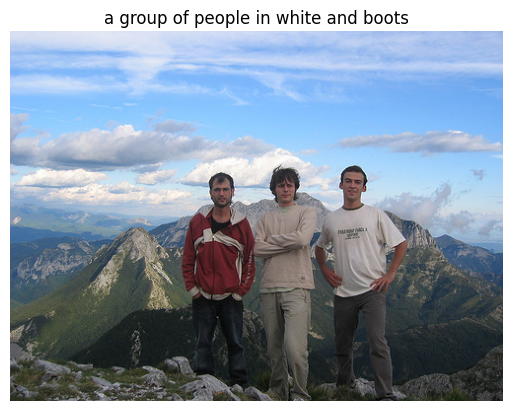

In [80]:
IMG_DIR = "/content/drive/MyDrive/images"
filename = "1413956047_c826f90c8b.jpg"
image_path = os.path.join(IMG_DIR, filename)

caption = generate_caption(model, image_path, vectorizer, word2idx, idx2word, temperature=0.9)

print(f"🖼️ Image: {image_path}")
print(f"📝 Caption: {caption}")

# Show the image
from tensorflow.keras.preprocessing.image import load_img
img = load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()


🖼️ Image: /content/drive/MyDrive/images/1622619190_d0b51aff28.jpg
📝 Caption: a brown dog runs in a field


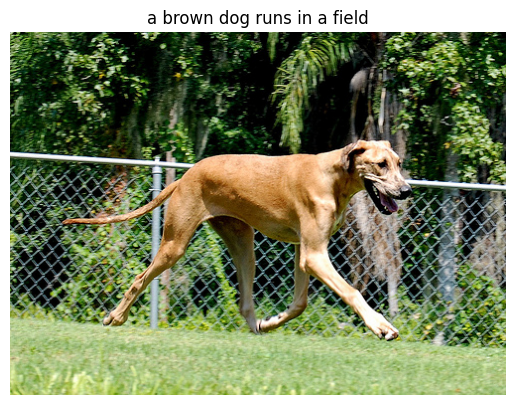

In [115]:
IMG_DIR = "/content/drive/MyDrive/images"
filename = "1622619190_d0b51aff28.jpg"
image_path = os.path.join(IMG_DIR, filename)

caption = generate_caption(model, image_path, vectorizer, word2idx, idx2word, temperature=0.9)

print(f"🖼️ Image: {image_path}")
print(f"📝 Caption: {caption}")

# Show the image
from tensorflow.keras.preprocessing.image import load_img
img = load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()


🖼️ Image: /content/drive/MyDrive/images/2054308369_f9c6ec7815.jpg
📝 Caption: a large brown dog is biting the ear of a woman s face


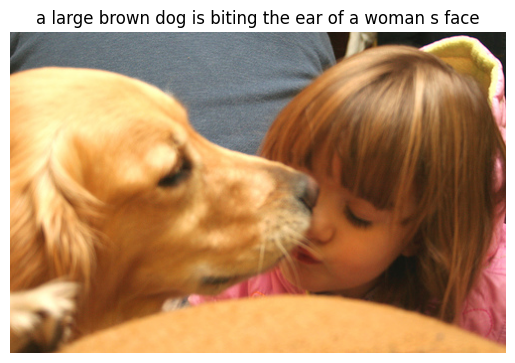

In [128]:

IMG_DIR = "/content/drive/MyDrive/images"
filename = "2054308369_f9c6ec7815.jpg"
image_path = os.path.join(IMG_DIR, filename)

caption = generate_caption(model, image_path, vectorizer, word2idx, idx2word, temperature=0.9)

print(f"🖼️ Image: {image_path}")
print(f"📝 Caption: {caption}")

# Show the image
from tensorflow.keras.preprocessing.image import load_img
img = load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()
